### <a href="https://www5.cs.fau.de/fileadmin/research/datasets/fundus-images/all.zip">Dataset</a>

### Load data

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import cv2
import sys
import time
import xgboost as xgb
from preprocess import clahe, sectioning, sectioning_img, hist_equalization
from unused import sectioning_, display_sections
from feature_extraction import extract_features, convert_to_feature_vec
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
sys.path.append('../')
from load_images import load

In [2]:
img_size = (512, 512)
X, y, masks = load(img_size)

CLAHE operation will be performed on images before sectioning.

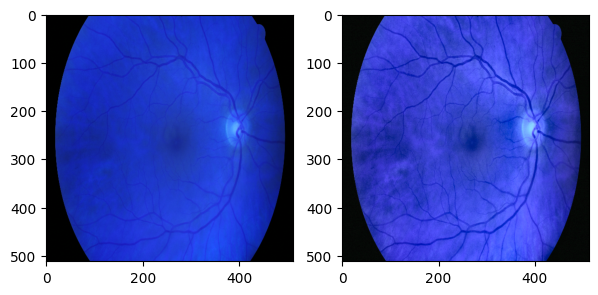

In [3]:
fig, ax = plt.subplots(1, 2, figsize=(7,4))
ax[0].imshow(X[1], cmap='gray')
ax[1].imshow(clahe(X[1]), cmap='gray')
plt.show()

### Divide image into NxN sections

In [4]:
n = 5
num_img = 1
sections, targets = sectioning(X, y, num_img, img_size, n)

### Convert sections to feature vectors

In [5]:
section_features = convert_to_feature_vec(sections)
X_train, X_test, y_train, y_test = train_test_split(section_features, targets, test_size=0.2, shuffle=True)

### Train XGBoost Classifier

In [7]:
xgb_clf = xgb.XGBClassifier()
xgb_clf.fit(X_train, y_train)

              precision    recall  f1-score   support

         0.0       0.97      0.99      0.98     47551
         1.0       0.86      0.69      0.77      4878

    accuracy                           0.96     52429
   macro avg       0.92      0.84      0.87     52429
weighted avg       0.96      0.96      0.96     52429



### Evaluate performance on unseen image

In [18]:
j = np.random.randint(0,len(X))
sections = sectioning_img(X[j], n)
X_new = np.zeros((sections.shape[0], 13))

for i in range(sections.shape[0]):
    X_new[i] = extract_features(sections[i])

y_new = y[j].flatten()
_, y_new = cv2.threshold(y_new, 128, 1, cv2.THRESH_BINARY)

Train set: 
               precision    recall  f1-score   support

           0       0.99      0.98      0.98    193118
           1       0.77      0.92      0.84     16597

    accuracy                           0.97    209715
   macro avg       0.88      0.95      0.91    209715
weighted avg       0.98      0.97      0.97    209715

------------------------------------------------------

Test set: 
               precision    recall  f1-score   support

           0       0.99      0.97      0.98     48512
           1       0.69      0.86      0.77      3917

    accuracy                           0.96     52429
   macro avg       0.84      0.92      0.87     52429
weighted avg       0.97      0.96      0.96     52429

------------------------------------------------------

Unseen image: 
              precision    recall  f1-score   support

           0       0.99      0.96      0.98    243171
           1       0.64      0.88      0.74     18973

    accuracy                  

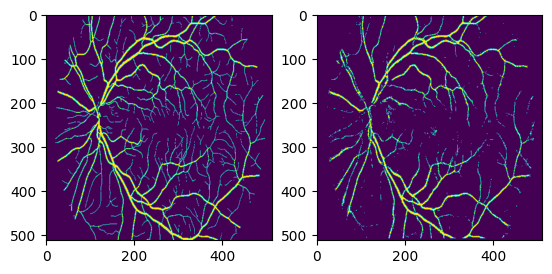

In [19]:
y_pred_train = xgb_clf.predict(X_train)
y_pred_test = xgb_clf.predict(X_test)
y_pred_new = xgb_clf.predict(X_new)

print(f'Train set: \n {classification_report(y_pred_train, y_train)}')
print('------------------------------------------------------\n')
print(f'Test set: \n {classification_report(y_pred_test, y_test)}')
print('------------------------------------------------------\n')
print(f'Unseen image: \n{classification_report(y_pred_new, y_new)}')

y_new = y_new.reshape(img_size)
y_pred_new = y_pred_new.reshape(img_size)
fig,ax = plt.subplots(1,2)
ax[0].imshow(y_new)
ax[1].imshow(y_pred_new)
plt.show()